In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon, shapiro, ranksums
from jmetal.core.algorithm import Algorithm
from jmetal.core.quality_indicator import *
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file, read_solutions

In [4]:
def generate_summary_from_experiment(input_dir, quality_indicators, summary_filename,
                                     reference_fronts = ''):
    reference_change = 2500
    
    if not quality_indicators:
        quality_indicators = []

    with open(summary_filename, "w+") as of:
        of.write("Algorithm,Problem,ExecutionId,IndicatorName,IndicatorValue\n")

    for dirname, _, filenames in os.walk(input_dir):
        for filename in filenames:
            try:
                # Linux filesystem
                algorithm, problem = dirname.split("/")[-2:]
            except ValueError:
                # Windows filesystem
                algorithm, problem = dirname.split("\\")[-2:]

            if "FUN" in filename:
                solutions = read_solutions(os.path.join(dirname, filename))
                run_tag = [s for s in filename.split(".") if s.isdigit()].pop()
                for indicator in quality_indicators:
                    reference_front_file = os.path.join(reference_fronts, problem + ".pf")

                    # Add reference front if any
                    if hasattr(indicator, "reference_front"):
                        if Path(reference_front_file).is_file():
                            reference_front = []
                            with open(reference_front_file) as file:
                                for line in file:
                                    reference_front.append([float(x) for x in line.split()])

                            indicator.reference_front = reference_front
                        else:
                            logger.warning("Reference front not found at", reference_front_file)

                    result = indicator.compute([solutions[i].objectives for i in range(len(solutions))])

                    # Save quality indicator value to file
                    with open(summary_filename, "a+") as of:
                        of.write(",".join([algorithm, problem, run_tag, indicator.get_short_name(), str(result)]))
                        of.write("\n")

In [13]:
filename = "summary-100k.csv"
datapath = "data-normals-100k"

In [14]:
generate_summary_from_experiment("data/{}".format(datapath), [InvertedGenerationalDistance(None)], filename,
                                "resources/reference_front")

In [15]:
df_100k = pd.read_csv("summary-100k.csv")
df_300k = pd.read_csv("summary-300k.csv")

df_smac_100k = pd.read_csv("summary-smac-100k.csv")
df_smac_300k = pd.read_csv("summary-smac-300k.csv")

In [53]:
df_100k[(df_100k["Algorithm"] == "SMPSO") & (df_100k["Problem"] == "MOP4")]["IndicatorValue"].mean()

0.8975945910090528

In [ ]:
get_stats()

In [16]:
algorithms = df_100k["Algorithm"].unique()
problems = df_100k["Problem"].unique()

In [18]:
print(algorithms)
print(problems)

['CMPSO' 'Epsilon-IBEA' 'MOEAD' 'NSGAII' 'NSGAIII' 'OMOPSO' 'SMPSO']
['DASCMOP1(5)' 'DASCMOP1(6)' 'DASCMOP1(7)' 'DASCMOP2(5)' 'DASCMOP2(6)'
 'DASCMOP2(7)' 'DASCMOP3(5)' 'DASCMOP3(6)' 'DASCMOP3(7)' 'DASCMOP4(5)'
 'DASCMOP4(6)' 'DASCMOP4(7)' 'DASCMOP5(5)' 'DASCMOP5(6)' 'DASCMOP5(7)'
 'DASCMOP6(5)' 'DASCMOP6(6)' 'DASCMOP6(7)' 'DTLZ1' 'DTLZ2' 'DTLZ3' 'DTLZ4'
 'DTLZ5' 'DTLZ6' 'DTLZ7' 'IMB1' 'IMB10' 'IMB11' 'IMB12' 'IMB13' 'IMB14'
 'IMB2' 'IMB3' 'IMB4' 'IMB5' 'IMB6' 'IMB7' 'IMB8' 'IMB9' 'LZ09_F1'
 'LZ09_F2' 'LZ09_F3' 'LZ09_F4' 'LZ09_F5' 'LZ09_F6' 'LZ09_F7' 'LZ09_F8'
 'LZ09_F9' 'MOP1' 'MOP2' 'MOP3' 'MOP4' 'MOP5' 'MOP6' 'MOP7' 'UF1' 'UF2'
 'UF3' 'UF4' 'UF5' 'UF6' 'UF7' 'UF8' 'UF9' 'WFG1' 'WFG2' 'WFG3' 'WFG4'
 'WFG5' 'WFG6' 'WFG7' 'WFG8' 'WFG9' 'ZDT1' 'ZDT2' 'ZDT3' 'ZDT4' 'ZDT6']


In [51]:
def get_stats(normal_df, smac_df, algorithm, problem):
    normals = normal_df[(normal_df["Algorithm"] == algorithm) & (normal_df["Problem"] == problem)]["IndicatorValue"]
    smac = smac_df[(smac_df["Algorithm"] == algorithm) & (smac_df["Problem"] == problem)]["IndicatorValue"]
    
    result = ranksums(normals, smac)
    
    return result

def write_stats(filename, normal_df, smac_df):
    with open(filename, "a") as f:
        for algorithm in algorithms:
            for problem in problems:
                normal_igd = normal_df[(normal_df["Algorithm"] == algorithm) & (normal_df["Problem"] == problem)]["IndicatorValue"].mean()
                smac_igd = smac_df[(smac_df["Algorithm"] == algorithm) & (smac_df["Problem"] == problem)]["IndicatorValue"].mean()
                result = get_stats(normal_df, smac_df, algorithm, problem)

                #algorithm, problem, normal igd, smac igd, p value
                #print("{},{},{},{},{}\n".format(algorithm, problem, normal_igd, smac_igd, result.pvalue))
                f.write("{},{},{},{},{}\n".format(algorithm, problem, normal_igd, smac_igd, result.pvalue))

In [52]:
write_stats("summary-statistics-100k.csv", df_100k, df_smac_100k)
write_stats("summary-statistics-300k.csv", df_300k, df_smac_300k)

In [88]:
def create_summary_df(normal_df, smac_df):
    summary_df = pd.DataFrame(columns=["Algorithm", "Problem", "Normal IGD", "SMAC IGD", "p-value", "Percentage difference"])
    
    for algorithm in algorithms:
        for problem in problems:
            normal_igd = normal_df[(normal_df["Algorithm"] == algorithm) & (normal_df["Problem"] == problem)]["IndicatorValue"].mean()
            smac_igd = smac_df[(smac_df["Algorithm"] == algorithm) & (smac_df["Problem"] == problem)]["IndicatorValue"].mean()
            result = get_stats(normal_df, smac_df, algorithm, problem)
            
            percent_diff = 100 * (normal_igd - smac_igd) / ((normal_igd + smac_igd) / 2.0)
            
            datarow = {"Algorithm": algorithm,
                       "Problem": problem,
                       "Normal IGD": normal_igd,
                       "SMAC IGD": smac_igd,
                       "p-value": result.pvalue,
                       "Percentage difference": percent_diff }
            
            if result.pvalue < 0.05:
                summary_df = summary_df.append(datarow, ignore_index=True)
            
    return summary_df
            

In [93]:
problems_cat1 = ["ZDT1", "ZDT2", "ZDT3", "ZDT4", "ZDT6"]
problems_cat2 = ["UF1", "UF2", "UF3", "LZ09_F1", "LZ09_F2", "LZ09_F3", "LZ09_F4", "LZ09_F5"]
problems_cat3 = ["UF4", "UF8", "UF10", "WFG4", "WFG5", "WFG6", "WFG7", "WFG8", "WFG9", 
                 "DTLZ2", "DTLZ3", "DTLZ4", "DTLZ5", "DTLZ6"]
problems_cat4 = ["UF7", "WFG1", "WFG3", "DTLZ1"]
problems_cat5 = ["UF5", "UF6", "UF9", "WFG2", "DTLZ7", "MOP4"]
problems_cat6 = ["MOP1", "MOP2", "MOP3", "MOP5", "MOP6", "MOP7", 
                 "IMB1", "IMB2", "IMB3", "IMB4", "IMB5", "IMB6", "IMB7", "IMB8", "IMB9", "IMB10"]
problems_cat7 = ["IMB11", "IMB12", "IMB13", "IMB14"]
problems_cat8 = ["DASCMOP{}(5)".format(i+1) for i in range(6)]
problems_cat9 = ["DASCMOP{}(6)".format(i+1) for i in range(6)]
problems_cat10 = ["DASCMOP{}(7)".format(i+1) for i in range(6)]

categories = {
    "1": problems_cat1,
    "2": problems_cat2,
    "3": problems_cat3,
    "4": problems_cat4,
    "5": problems_cat5,
    "6": problems_cat6,
    "7": problems_cat7,
    "8": problems_cat8,
    "9": problems_cat9,
    "10": problems_cat10
}

In [76]:
summary_df_100k = create_summary_df(df_100k, df_smac_100k)
summary_df_300k = create_summary_df(df_300k, df_smac_300k)

/home/sy6u19/Documents/cmlsga-jmetalpy/env3.7/lib/python3.7/site-packages/scipy/stats/stats.py:7784: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


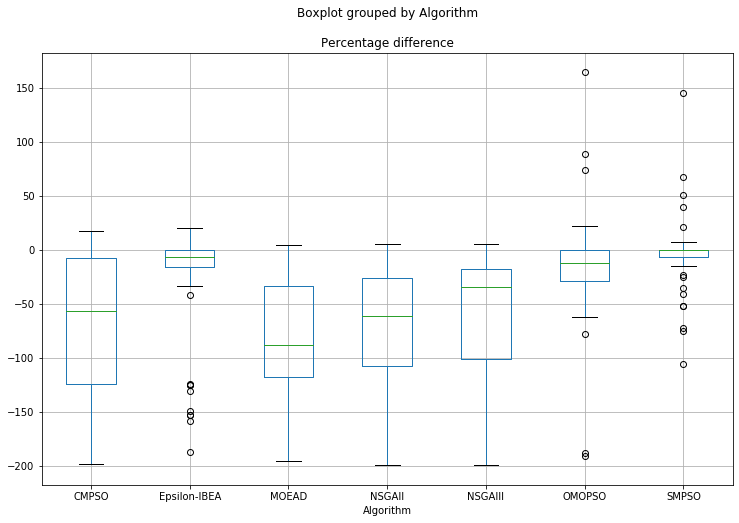

In [77]:
summary_df_100k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))

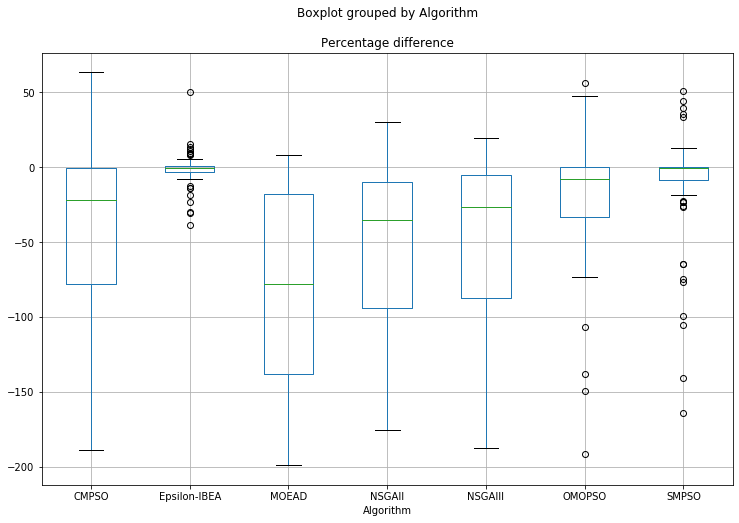

In [80]:
summary_df_300k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))

In [81]:
summary_df_100k_significant = create_summary_df(df_100k, df_smac_100k)
summary_df_300k_significant = create_summary_df(df_300k, df_smac_300k)

/home/sy6u19/Documents/cmlsga-jmetalpy/env3.7/lib/python3.7/site-packages/scipy/stats/stats.py:7784: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


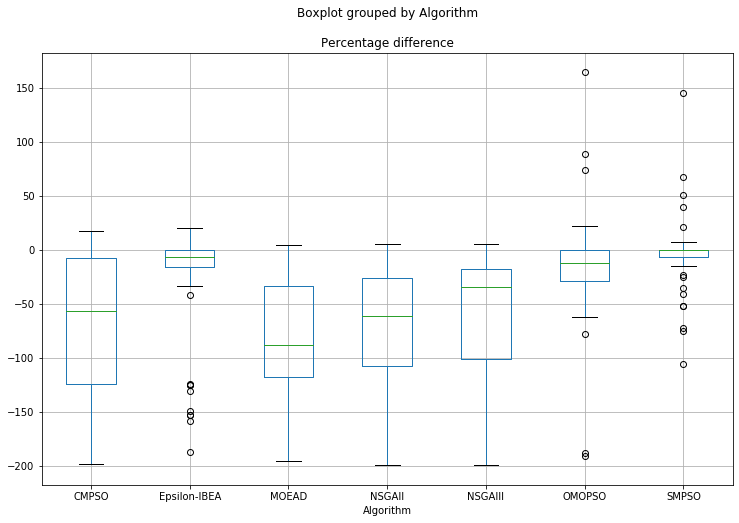

In [82]:
summary_df_100k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))

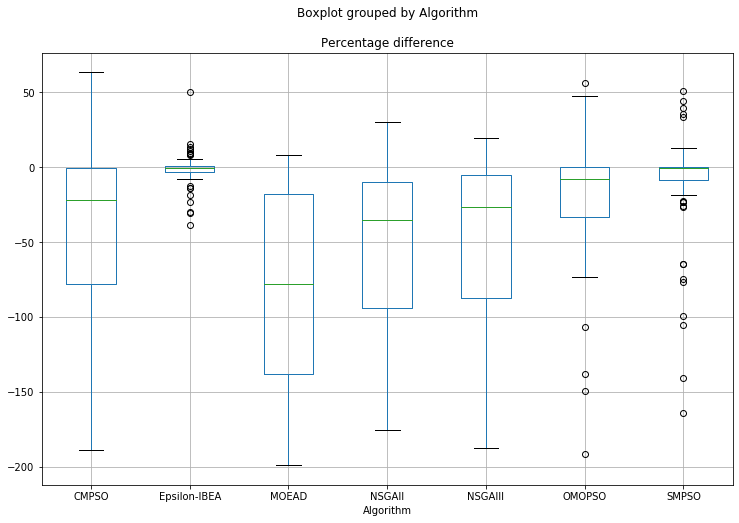

In [83]:
summary_df_300k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))

In [89]:
summary_df_100k["Problem"].unique()

array(['DASCMOP1(5)', 'DASCMOP1(6)', 'DASCMOP1(7)', 'DASCMOP2(5)',
       'DASCMOP2(6)', 'DASCMOP2(7)', 'DASCMOP3(5)', 'DASCMOP3(6)',
       'DASCMOP3(7)', 'DASCMOP4(5)', 'DASCMOP4(6)', 'DASCMOP4(7)',
       'DASCMOP5(5)', 'DASCMOP5(6)', 'DASCMOP5(7)', 'DASCMOP6(5)',
       'DASCMOP6(6)', 'DASCMOP6(7)', 'DTLZ1', 'DTLZ2', 'DTLZ3', 'DTLZ4',
       'DTLZ5', 'DTLZ6', 'DTLZ7', 'IMB1', 'IMB10', 'IMB11', 'IMB12',
       'IMB13', 'IMB14', 'IMB2', 'IMB3', 'IMB4', 'IMB5', 'IMB6', 'IMB7',
       'IMB8', 'IMB9', 'LZ09_F1', 'LZ09_F2', 'LZ09_F3', 'LZ09_F4',
       'LZ09_F5', 'LZ09_F6', 'LZ09_F7', 'LZ09_F8', 'LZ09_F9', 'MOP1',
       'MOP2', 'MOP3', 'MOP4', 'MOP5', 'MOP6', 'MOP7', 'UF1', 'UF2',
       'UF3', 'UF4', 'UF5', 'UF6', 'UF7', 'UF8', 'UF9', 'WFG1', 'WFG2',
       'WFG3', 'WFG4', 'WFG5', 'WFG6', 'WFG7', 'WFG8', 'WFG9', 'ZDT1',
       'ZDT2', 'ZDT3', 'ZDT4', 'ZDT6'], dtype=object)

In [87]:
summary_df_300k

,Algorithm,Problem,Normal IGD,SMAC IGD,p-value,Percentage difference
0,CMPSO,DASCMOP1(5),0.031995,0.070799,1.666535e-06,-75.498698
1,CMPSO,DASCMOP1(6),0.291361,0.291078,7.449863e-01,0.097313
2,CMPSO,DASCMOP1(7),0.329126,0.554286,7.786348e-03,-50.975131
3,CMPSO,DASCMOP2(5),0.034437,0.044478,3.450051e-02,-25.448252
4,CMPSO,DASCMOP2(6),0.160670,0.259882,2.804705e-01,-47.181949
...,...,...,...,...,...,...
541,SMPSO,ZDT1,0.003661,0.003655,2.871949e-11,0.162722
542,SMPSO,ZDT2,0.003788,0.003786,2.871949e-11,0.054229
543,SMPSO,ZDT3,0.004235,0.004281,2.871949e-11,-1.091258
544,SMPSO,ZDT4,0.003659,0.003665,2.871949e-11,-0.154761


In [61]:
smpso = df[(df["Algorithm"] == "SMPSO") & (df["Problem"] == "ZDT6")]["IndicatorValue"]

In [62]:
smpso_epi = df[(df["Algorithm"] == "SMPSO-epi") & (df["Problem"] == "ZDT6")]["IndicatorValue"]

In [44]:
print(wilcoxon(smpso, smpso_epi, alternative="less"))

WilcoxonResult(statistic=0.0, pvalue=0.002531016063133932)


In [71]:
for problem in problems:
    smpso = df[(df["Algorithm"] == "SMPSO") & (df["Problem"] == problem)]["IndicatorValue"]
    smpso_epi = df[(df["Algorithm"] == "SMPSO-epi") & (df["Problem"] == problem)]["IndicatorValue"]
    
    print("Problem: {}".format(problem))
    print(smpso)
    print(smpso_epi)
    print(ranksums(smpso, smpso_epi))

Problem: ZDT2
50    0.003789
51    0.003821
52    0.003756
53    0.003787
54    0.003749
55    0.003780
56    0.003791
57    0.003735
58    0.003774
59    0.003808
Name: IndicatorValue, dtype: float64
0    0.003845
1    0.003900
2    0.003898
3    0.003843
4    0.003920
5    0.003921
6    0.003911
7    0.003948
8    0.003948
9    0.003918
Name: IndicatorValue, dtype: float64
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
Problem: ZDT3
60    0.004236
61    0.004254
62    0.004153
63    0.004347
64    0.004363
65    0.004250
66    0.004227
67    0.004252
68    0.004371
69    0.004381
Name: IndicatorValue, dtype: float64
10    0.004890
11    0.004776
12    0.004850
13    0.004944
14    0.004995
15    0.004941
16    0.004740
17    0.004663
18    0.004752
19    0.005105
Name: IndicatorValue, dtype: float64
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
Problem: ZDT4
70    0.003677
71    0.003677
72    0.003682
73    0.003675
74    0.